/Users/omerhacohen/ws/pixel-brain/venv/lib/python3.8/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/Users/omerhacohen/ws/pixel-brain/venv/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [15:49:41] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Testing RMSE: 0.7054217854172583
Testing AUC: 0.5


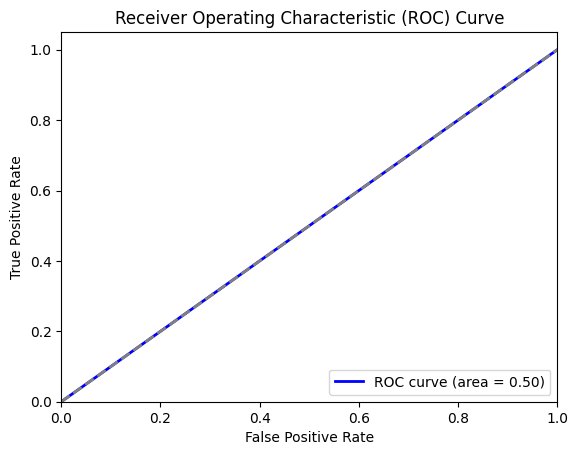

In [1]:
from pixelbrain.database_processors.xgboost_processor import XGBoostDatabaseRegressorTrainer, XGBoostDatabasProcessor
from pixelbrain.database import Database
import os
mongo_key=os.getenv("MONGO_URL")
db = Database(database_id="Selfyx", mongo_key=mongo_key)

data_field_names = [
    "cfg_scale",
    "pick_score",
    "similarity_score_nearest",
    "similarity_score_average_k_nearest",
    "similarity_score_maximum_distance",
    "generated_epoch"
]

metric_field_name = "human_rating"
trainer = XGBoostDatabaseRegressorTrainer(db, data_field_names, metric_field_name)
rmse, auc = trainer.fit(save_model_path="xgboost_rating_model.pkl", auc_threshold=4, plot_auc_curve=True)



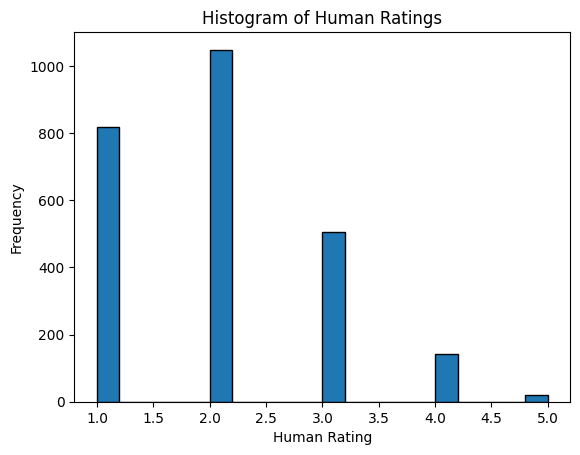

In [2]:
import matplotlib.pyplot as plt

# Fetch the data from the database
data = db.find_images_with_fields([metric_field_name])

# Extract the metric values
metric_values = [record[metric_field_name] for record in data]

# Plot the histogram
plt.hist(metric_values, bins=20, edgecolor='black')
plt.title('Histogram of Human Ratings')
plt.xlabel('Human Rating')
plt.ylabel('Frequency')
plt.show()


In [3]:
predictor = XGBoostDatabaseProcessor(db, data_field_names, model_path="xgboost_rating_model.pkl")
prep_data = predictor.get_prepared_data()
predictions = predictor.predict(prep_data)

# Plot the histogram
plt.hist(predictions, bins=20, edgecolor='black')
plt.title('Histogram of Model Ratings')
plt.xlabel('Model Rating')
plt.ylabel('Frequency')
plt.show()

NameError: name 'XGBoostDatabaseProcessor' is not defined